## 1. Setting up the environment

### Importing the necessary packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import pandas as pd
import time
import math
import random
import time
import dask
import dask.bag as db

### Creating Dask Cluster for Parallel Processing
taken from https://github.com/pangeo-data/pangeo-geospatial-examples/blob/master/analyze_REMA.ipynb

In [2]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster(n_workers=20)
client = Client(cluster)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.5.101:40283
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-74c69b1c-a154-11ea-81ef-2646e2b16b71
distributed.core - INFO - Starting established connection


### Setting up the plotting style

In [3]:
plt.rcParams.update({
    'font.sans-serif': 'Arial',
    'font.family': 'Arial',
    'font.size': 7,
    'grid.linewidth': 0.1,
    'axes.titlesize': 8,
    'axes.titleweight' : 'bold',
    'axes.labelsize': 8,
    'axes.labelweight': 'bold'
})

## 2.Preparing for temperature profile calculations

#### Defining constants

In [4]:
c_i = 2e3 # Heat capacity of ice
c_r = 7.9e2 # Heat capacity of basal rock
k_i = 2.3 # Thermal conductivity of ice
k_r = 2.8 # Thermal conductivity of basal rock
rho_i = 918.9 # Density of ice
rho_r = 2750 # Density of basal rock
alpha_i = k_i / rho_i / c_i # Alpha
alpha_r = k_r / rho_r / c_r # Alpha for basal rock
n = 3 # Glen's flow law exponent
g = 9.81 # Gravitational acceleration
A = 2e-16 # Rheological constant determining soft ice as a function of temperature
G = 668e-4 # Geothermal heat flux

#### Defining spatial and temporal domains / resolution

In [5]:
Hi = 1860 # Ice thickness (average from PISM model outputs)
dz = 10  # Vertical resolution / calculation step
Hr = 500  # Rock thickness
z = np.linspace(-Hr, Hi, (Hi+Hr)/dz + 1)   # Space calculation domain for ice and rock
zi = np.linspace(0, Hi, Hi/dz + 1)  # Space calculation domain for ice
zr = np.linspace(-Hr, 0, Hr/dz + 1) #  Space calculation domain for rock
l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
Lz = len(z)  # Number of elements in space domain
Lzi = len(zi) #  Number of elements in space domain for ice
Lzr = len(zr) #  Number of elements in space domain for rock

dt_years = 1  # Temporal resolution / calculation time step in years
dt = (dt_years * (365*24*60*60)) #  Temporal resolution / calculation time step in seconds
t_steady_years_total = 5e5 # Time in years typically more than enough to achieve steady state
t_steady = np.linspace(0, t_steady_years_total * (365*24*60*60), dt)  # Total steady statre simulation time vector
Lt_steady = len(t_steady)

a_yr = 0.2338 # Defining accumulation in m/yr
a = a_yr / (365*24*60*60) # Defining accumulation in m/s

## Reading random temperature curves created based on prior distributions based on PISM
temphistories_resampled = pd.read_csv('temphistories_resampled_20.csv', header=None)

Tsteady = np.zeros((Lz,Lt_steady)) # Creating matrix to record temperature vectors over time for comparison
Tfinal_varT = np.zeros((Lz,len(temphistories_resampled))) # Creating an empty matrix to record the result

#### Checking the random temperature curves to be used in Monte-Carlo simulation

In [6]:
temphistories_resampled

,0,1,2,3,4,5,6,7,8,9,...,19991,19992,19993,19994,19995,19996,19997,19998,19999,20000
0,-18.310837,-18.311447,-18.312057,-18.312668,-18.313278,-18.313889,-18.314499,-18.315109,-18.315720,-18.316315,...,-19.871735,-19.863083,-19.854431,-19.845779,-19.837128,-19.828461,-19.819794,-19.811127,-19.802460,-19.793777
1,-23.191925,-23.184464,-23.177002,-23.169540,-23.162079,-23.154633,-23.147171,-23.139725,-23.132278,-23.124832,...,-31.541107,-31.539902,-31.538681,-31.537460,-31.536240,-31.535019,-31.533798,-31.532578,-31.531357,-31.530136
2,-14.509460,-14.516479,-14.523499,-14.530518,-14.537537,-14.544525,-14.551544,-14.558563,-14.565552,-14.572571,...,-18.730591,-18.718842,-18.707092,-18.695343,-18.683594,-18.671844,-18.660080,-18.648315,-18.636551,-18.624786
3,-14.509460,-14.519684,-14.529877,-14.540100,-14.550293,-14.560486,-14.570709,-14.580902,-14.591095,-14.601257,...,-40.543915,-40.553726,-40.563522,-40.573318,-40.583130,-40.592926,-40.602737,-40.612549,-40.622360,-40.632172
4,-23.191925,-23.193344,-23.194778,-23.196198,-23.197617,-23.199036,-23.200455,-23.201874,-23.203278,-23.204697,...,-18.284012,-18.275665,-18.267319,-18.258972,-18.250610,-18.242264,-18.233902,-18.225540,-18.217178,-18.208801
5,-30.597382,-30.604980,-30.612564,-30.620148,-30.627731,-30.635300,-30.642883,-30.650452,-30.658005,-30.665573,...,-18.317215,-18.305191,-18.293167,-18.281128,-18.269089,-18.257034,-18.244995,-18.232925,-18.220871,-18.208801
6,-36.924759,-36.921082,-36.917419,-36.913742,-36.910065,-36.906387,-36.902710,-36.899048,-36.895370,-36.891693,...,-40.591019,-40.595596,-40.600159,-40.604736,-40.609314,-40.613892,-40.618454,-40.623032,-40.627594,-40.632172
7,-18.176010,-18.186829,-18.197662,-18.208481,-18.219284,-18.230103,-18.240906,-18.251709,-18.262497,-18.273300,...,-19.855225,-19.848419,-19.841599,-19.834778,-19.827942,-19.821121,-19.814285,-19.807449,-19.800613,-19.793777
8,-36.924759,-36.915039,-36.905334,-36.895615,-36.885910,-36.876205,-36.866501,-36.856796,-36.847092,-36.837402,...,-18.676178,-18.670471,-18.664764,-18.659058,-18.653351,-18.647644,-18.641937,-18.636215,-18.630508,-18.624786
9,-18.176010,-18.177536,-18.179062,-18.180588,-18.182098,-18.183624,-18.185150,-18.186661,-18.188171,-18.189682,...,-18.791550,-18.773041,-18.754532,-18.736023,-18.717499,-18.698975,-18.680435,-18.661896,-18.643341,-18.624786


#### An example of T(t) curve on a plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


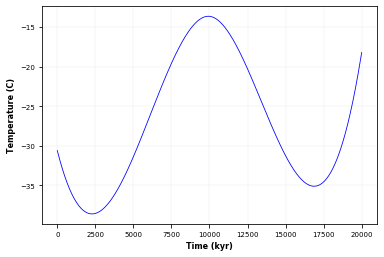

In [7]:
plt.figure(0)
plt.plot(temphistories_resampled.values[5,:20000],'b', linewidth=0.8)
plt.ylabel('Temperature (C)')
plt.xlabel('Time (kyr)')
plt.grid(True)

## 3. Calculating temperature profiles in a loop

In [8]:
tic = time.perf_counter()

for TT in range(0,len(temphistories_resampled.values)):

    Ts_surf_steady = temphistories_resampled.values[TT,0] # Taking the first value of the imported Monte-Carlo surface temperature vectors
    Ts = -z*0 + Ts_surf_steady

    ## Steady state temperature profile calculation for ice-shelf setting
    
    for i in range(1, Lt_steady):

        # Grounded ice vertical velocity profile

        dws = a  # -((Hi(jj) - Hi(jj - 1)) / dt); # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt


        # Above ice-rock interface

        Ts[l:-2] = Ts[l:-2] + dt*(alpha_i*(Ts[l+1:-1]-2*Ts[l:-2]+Ts[l-1:-3])/dz**2 - np.multiply(ws[1:-2],(Ts[l+1:-1]-Ts[l-1:-3])/(2*dz)))
        Ts[-1] = Ts_surf_steady # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors

        # Below ice-rock interface
        
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dz**2
        Ts[0] = Ts[1] + (G/k_r*dz)
        
        
        # Recording the result into an empty matrix for comparison
        
        Tsteady[:,i] = Ts[:]
        if (Tsteady[:, i] - Tsteady[:, i - 1]).all() <= 1e-6:
            break # Stopping when steady state is reached
        
        

    ## Perturbing steady state temperature profile calculated above with variable temperatures

    for j in range(0, 20000):

        # # Grounded ice vertical velocity profile

        dws = a # -((Hi(jj) - Hi(jj - 1)) / dt); # When thickness is variable through time
        wzt = (1 - (((n+2)/(n+1))*(1-zi/Hi)) + (1/(n+1))*np.power((1-zi/Hi),(n + 2)))
        ws = -dws*wzt

        
        # Above ice-rock interface

        Ts[l:-2] = Ts[l:-2] + dt*(alpha_i*(Ts[l+1:-1]-2*Ts[l:-2]+Ts[l-1:-3])/dz**2 - np.multiply(ws[1:-2],(Ts[l+1:-1]-Ts[l-1:-3])/(2*dz)))
        Ts[-1] = temphistories_resampled.values[TT,j]  # Here is where the temperature forcing comes into play
        Ts[-2] = Ts[-1]

        # Below ice-rock interface
        
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dz**2
        Ts[0] = Ts[1] + (G / k_r * dz)
      
        Tfinal_varT[:,TT] = Ts # Recording temperature profile into the final matrix
        
toc = time.perf_counter()
print(f"Completed in {toc - tic:0.4f} seconds")

distributed.scheduler - INFO - Register tcp://10.32.104.7:42105
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.104.7:42105
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.39.4:33749
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.39.4:33749
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.39.5:34107
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.39.5:34107
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.51.5:38117
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.51.5:38117
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.50.5:36677
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.50.5:36677
distributed.core - IN

Completed in 35.1590 seconds


#### Seeing the resulting T(z) on a figure

Text(0.5, 1.0, 'Time: 20000 years')

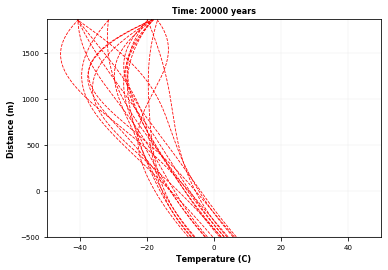

In [9]:
plt.figure(1)
plt.plot(Tfinal_varT[:,:-1],z,'r--', linewidth=0.8)
plt.axis([-50, 50, -Hr, Hi])
plt.ylabel('Distance (m)')
plt.xlabel('Temperature (C)')
plt.grid(True)
plt.title("Time: " + str(20000) + " years")

## 4. Creating a function for temperature calculation (based on 3) to be used in dask

In [10]:
def tempcalc(temphistories_resampled):
    
    Ts_surf_steady = temphistories_resampled[0]
    Ts = -z*0 + Ts_surf_steady
        
    ## Steady state temperature profile calculation for ice-shelf setting
    
    for i in range(1, Lt_steady):

        # Grounded ice vertical velocity profile

        dws = a  # -((Hi(jj) - Hi(jj - 1)) / dt); # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt

        # Ice shelf vertical velocity profile
        # w = -np.linspace(0,a,Lzi)

        # Above ice-rock interface

        Ts[l:-2] = Ts[l:-2] + dt*(alpha_i*(Ts[l+1:-1]-2*Ts[l:-2]+Ts[l-1:-3])/dz**2 - np.multiply(ws[1:-2],(Ts[l+1:-1]-Ts[l-1:-3])/(2*dz)))
        Ts[-1] = temphistories_resampled[0]

        # Below ice-rock interface
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dz**2
        Ts[0] = Ts[1] + (G/k_r*dz)

        Tsteady[:,i] = Ts[:]

        deltaT = Tsteady[:,i]-Tsteady[:,i-1]
        deltaTsum = abs(sum(deltaT))

        if (Tsteady[:, i] - Tsteady[:, i - 1]).all() <= 1e-6:
            break # Stopping when steady state is reached


    ## Perturbing steady state with grounding event

    for j in range(0, 20000):

        # # Grounded ice vertical velocity profile

        dws = a # -((Hi(jj) - Hi(jj - 1)) / dt); # When thickness is variable through time
        wzt = (1 - (((n+2)/(n+1))*(1-zi/Hi)) + (1/(n+1))*np.power((1-zi/Hi),(n + 2)))
        ws = -dws*wzt

        # Above ice-rock interface

        Ts[l:-2] = Ts[l:-2] + dt*(alpha_i*(Ts[l+1:-1]-2*Ts[l:-2]+Ts[l-1:-3])/dz**2 - np.multiply(ws[1:-2],(Ts[l+1:-1]-Ts[l-1:-3])/(2*dz)))
        Ts[-1] = temphistories_resampled[j]
        Ts[-2] = Ts[-1]

        # Below ice-rock interface
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dz**2
        Ts[0] = Ts[1] + (G / k_r * dz)

    return Ts

#### Trying out the function on a sample T(t) row

In [11]:
tic = time.perf_counter()
result = tempcalc(temphistories_resampled.values[2,:])
toc = time.perf_counter()
print(f"Completed in {toc - tic:0.4f} seconds")

Completed in 1.4625 seconds


#### Comparing the resulting T(t) with the same calculation within a loop made in 3.

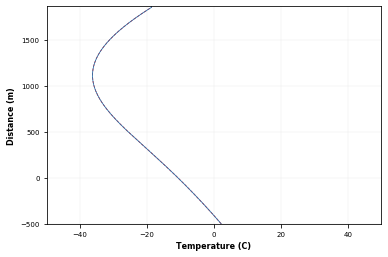

In [12]:
plt.figure(1)
plt.plot(result,z,'r--',Tfinal_varT[:,2],z, linewidth=0.8)
plt.axis([-50, 50, -Hr, Hi])
plt.ylabel('Distance (m)')
plt.xlabel('Temperature (C)')
plt.grid(True)

### Trying out calculation of temperature profiles in bulk using function

In [13]:
%%time

Tfinal_varT_calc_func = []

for parameters in temphistories_resampled.values[:len(temphistories_resampled)]:
    resulttemp = tempcalc(parameters)
    Tfinal_varT_calc_func.append(resulttemp)
    
Tfinal_varT_calc_func = np.array(Tfinal_varT_calc_func)
Tfinal_varT_calc_func = np.transpose(Tfinal_varT_calc_func)

CPU times: user 33.5 s, sys: 6.92 s, total: 40.4 s
Wall time: 31.8 s


#### Check that results are the same as those calculated in 3.

In [14]:
Tfinal_varT_calc_func == Tfinal_varT

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

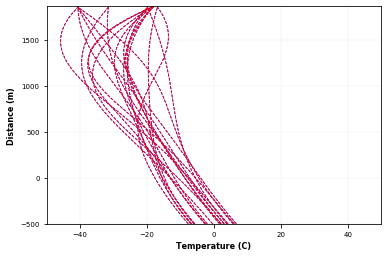

In [15]:
plt.figure(1)
plt.plot(Tfinal_varT_calc_func[:,:-1],z,'b--',Tfinal_varT[:,:-1],z,'r--',linewidth=0.8)
plt.axis([-50, 50, -Hr, Hi])
plt.ylabel('Distance (m)')
plt.xlabel('Temperature (C)')
plt.grid(True)

## 5. Implementing dask as in the following tutorial: https://examples.dask.org/applications/embarrassingly-parallel.html

### Defining computation calling function

In [16]:
import time
import random

def costly_simulation(list_param):
    time.sleep(random.random())
    return sum(list_param)

In [17]:
# %time costly_simulation([1, 2, 3, 4])

In [18]:
import pandas as pd
import numpy as np

input_params = pd.DataFrame(np.random.random(size=(20000, 20)))
#                             ,columns=['param_a', 'param_b', 'param_c', 'param_d'])
input_params.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.156887,0.002947,0.242231,0.800707,0.468042,0.695987,0.165311,0.577144,0.674832,0.108380,0.993464,0.995563,0.914806,0.157568,0.934367,0.107557,0.298330,0.197815,0.066030,0.351044
1,0.708413,0.188957,0.960127,0.554808,0.320916,0.583030,0.491313,0.748928,0.608581,0.854179,0.114797,0.915602,0.712953,0.968868,0.740810,0.417012,0.517266,0.537331,0.902017,0.656155
2,0.684938,0.237749,0.442125,0.569036,0.126645,0.649296,0.435687,0.514510,0.278908,0.914469,0.852022,0.697860,0.742293,0.650700,0.740773,0.831257,0.693241,0.468159,0.756675,0.137860
3,0.830165,0.877369,0.436407,0.364685,0.467171,0.026793,0.809099,0.693957,0.499727,0.780957,0.346996,0.795053,0.678865,0.115502,0.290279,0.591792,0.898713,0.808852,0.472403,0.258235
4,0.787613,0.079071,0.843956,0.088888,0.554863,0.769076,0.134231,0.787534,0.952997,0.037004,0.663803,0.726320,0.320154,0.188374,0.412217,0.760495,0.062838,0.503502,0.719298,0.344563


### Trying the function in a loop and timing it

In [19]:
%%time

results = []

for parameters in input_params.values[:10]:
    result = costly_simulation(parameters)
    results.append(result)
results[:5]

CPU times: user 125 ms, sys: 16.4 ms, total: 141 ms
Wall time: 3.26 s


[8.909013304153174,
 12.502061103477113,
 11.424203544560141,
 11.043020810834921,
 9.736797401888875]

### Using Dask Delayed to run in parallel and timing it

In [20]:
%%time

lazy_results = []

for parameters in input_params.values[:10]:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

futures = dask.persist(*lazy_results)  # trigger computation in the background

results = dask.compute(*futures)
results[:5]

CPU times: user 82.8 ms, sys: 11.4 ms, total: 94.2 ms
Wall time: 1.03 s


(8.909013304153174,
 12.502061103477113,
 11.424203544560141,
 11.043020810834921,
 9.736797401888875)

## 6. Using Dask procedures identical to 5. for our temperature calculation function

In [21]:
#### Repeating our calculation of temperature profiles in bulk using function for co

In [22]:
%%time

Tfinal_varT_calc_func = []

for parameters in temphistories_resampled.values:
    resulttemp = tempcalc(parameters)
    Tfinal_varT_calc_func.append(resulttemp)
    
Tfinal_varT_calc_func = np.array(Tfinal_varT_calc_func)
Tfinal_varT_calc_func = np.transpose(Tfinal_varT_calc_func)

CPU times: user 30.4 s, sys: 6.81 s, total: 37.2 s
Wall time: 29.2 s


In [23]:
%%time

Tfinal_varT_calc_func_dask = []

for parameters in temphistories_resampled.values[:4]:
    resulttempdask = dask.delayed(tempcalc)(parameters)
    Tfinal_varT_calc_func_dask.append(resulttempdask)

CPU times: user 1.37 ms, sys: 41 µs, total: 1.41 ms
Wall time: 982 µs


In [24]:
Tfinal_varT_calc_func_dask

[Delayed('tempcalc-2d40b356-53d3-4376-b596-bc4b9ac8384e'),
 Delayed('tempcalc-4e4ccd60-663f-4aae-b47f-9594f4acdc67'),
 Delayed('tempcalc-236fb726-16ff-4d81-9ac6-8a60187353d9'),
 Delayed('tempcalc-f7162db2-bd2c-4fad-ba0b-b59fecf1cfb0')]

### The code above worked ok until we try to implement dask.persist and/or .compute below, which yields the kernel error:

In [25]:
# %%time
# futures_temp = dask.persist(*Tfinal_varT_calc_func_dask)

In [ ]:
results_temp = dask.compute(*Tfinal_varT_calc_func_dask)